<a href="https://colab.research.google.com/github/truc-h-nguyen/Toddler-activity-suggestions/blob/main/COCO_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A. Preparation**

Load needed libraries. Then in the next part, we'll load "bowl" dataset, create masks, then create image augmentation for training.

In [ ]:
!pip install fiftyone
import fiftyone.zoo as foz
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from itertools import product

     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 559 kB 35.0 MB/s 
     |████████████████████████████████| 106 kB 33.0 MB/s 
     |████████████████████████████████| 79.9 MB 25 kB/s 
     |████████████████████████████████| 131 kB 49.6 MB/s 
     |████████████████████████████████| 631 kB 44.6 MB/s 
     |████████████████████████████████| 29.2 MB 26 kB/s 
     |████████████████████████████████| 13.2 MB 163 kB/s 
     |████████████████████████████████| 226 kB 50.2 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 47.6 MB 16 kB/s 
     |████████████████████████████████| 83 kB 1.8 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 79 kB 7.6 MB/s 
     |██████████████████████████

In [ ]:
!conda install -c conda-forge keras
!pip install git+https://github.com/qubvel/efficientnet
!pip install git+https://github.com/qubvel/classification_models.git
!pip install git+https://github.com/qubvel/segmentation_models
!pip install git+https://github.com/albu/albumentations
!pip install tta-wrapper

/bin/bash: conda: command not found
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-w4patpso
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-w4patpso
     |████████████████████████████████| 50 kB 2.6 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=e9d0b835bd13575e258a87eb75f582b69684843d7fbbe4e21776904712835005
  Stored in directory: /tmp/pip-ephem-wheel-cache-1oh_6_kd/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-ftmv4btn
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-ftmv4btn
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=8441809b377fdc1c042412221d2b7fee5d0608

In [ ]:
!pip install -U albumentations

In [ ]:
import albumentations as A
import random

In [ ]:
import os
import shutil
import glob
import random
import cv2

**B. "Bowl" dataset**

In [ ]:
bowl_set = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=["bowl"],
    max_samples=40,
)

 100% |██████|    1.9Gb/1.9Gb [16.6s elapsed, 0s remaining, 109.5Mb/s]      
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |████████████████████| 40/40 [20.3s elapsed, 0s remaining, 1.9 images/s]      
Writing annotations for 40 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |███████████████████| 40/40 [1.4s elapsed, 0s remaining, 29.0 samples/s]         
Dataset 'coco-2017-train-40' created


In [ ]:
for idx, sample in enumerate(bowl_set):
    if idx > 6:
        break
    img = sample['filepath'] #/root/fiftyone/coco-2017/train/data/000000000590.jpg
    img = mpimg.imread(img)
    useful_detections = [d for d in sample['ground_truth']['detections'] if d['label'] in ['bowl']]
    bbox = useful_detections[0]['bounding_box']

[0.0, 0.03370892018779342, 1.0, 0.9483098591549296]


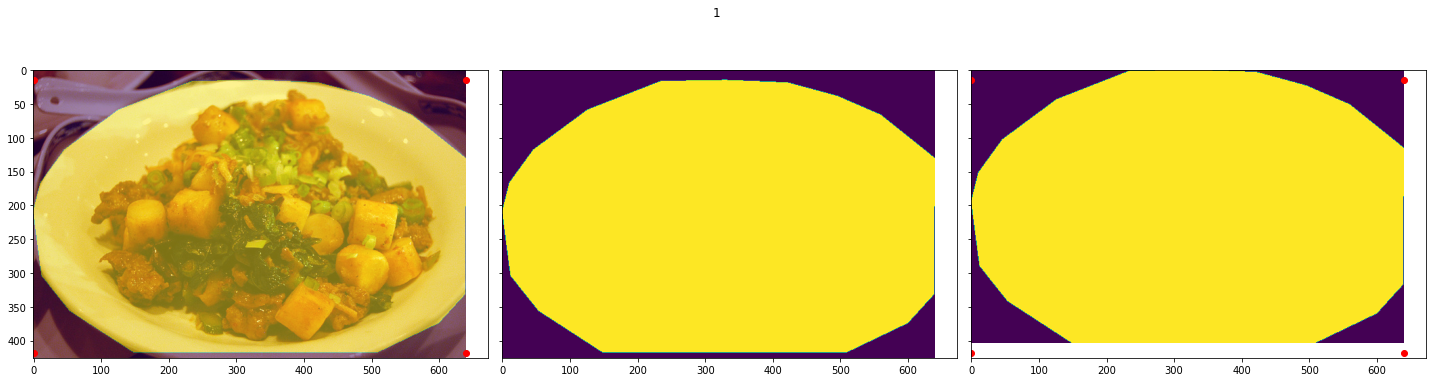

In [ ]:
x,y,w,h = bbox
print(bbox)
mask = np.zeros(img.shape[:2])    
def possible_slices(x,w,y,h):
        xslices = [
                   slice(int(np.floor(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.floor(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
        ]
        yslices = [
                   slice(int(np.floor(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.floor(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
        ]
        return list(product(xslices,yslices))

for detection in range(len(useful_detections)):
      bbox = useful_detections[detection]['bounding_box']
      x,y,w,h = bbox
      all_possible_slices = possible_slices(x,w,y,h)
    
      completed = False
      for xslice, yslice in all_possible_slices:
          if completed: continue
          try:
              mask[yslice, xslice] += useful_detections[detection]['mask']
              completed = True
          except:
              pass

fig, ax = plt.subplots(ncols=3, figsize=(20,6), sharex=True, sharey=True)
fig.suptitle(len(useful_detections))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].scatter(img.shape[1] * np.array([x,x,x+w,x+w]), img.shape[0] * np.array([y,y+h,y,y+h]), color='r')
ax[2].imshow(useful_detections[0]['mask'])
ax[0].imshow(mask, alpha=0.5)
ax[0].scatter(img.shape[1] * np.array([x,x,x+w,x+w]), img.shape[0] * np.array([y,y+h,y,y+h]), color='r')
plt.tight_layout()
plt.show()

**Transform**

In [ ]:
img_size = 200
transform = A.Compose([
    A.Resize(img_size, img_size, p=1),
    A.HorizontalFlip(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.9,p=0.2),
    A.Blur(blur_limit=20,p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Transpose(p=0.4),
    #A.HueSaturationValue(p=0.5)
])

**Create img and mask array**

In [ ]:
mask_array = []
img_array = []
for idx, sample in enumerate(bowl_set):
  img = sample['filepath']
  img = mpimg.imread(img)
  img_array.append(img)
  useful_detections = [d for d in sample['ground_truth']['detections'] if d['label'] in ['bowl']]
  bbox = useful_detections[0]['bounding_box']
  x,y,w,h = bbox
  mask = np.zeros(img.shape[:2])
  stacked_mask = np.zeros(img.shape[:2])    
  def possible_slices(x,w,y,h):
        xslices = [
                   slice(int(np.floor(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.floor(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
        ]
        yslices = [
                   slice(int(np.floor(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.floor(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
        ]
        return list(product(xslices,yslices))

  for detection in range(len(useful_detections)):
      bbox = useful_detections[detection]['bounding_box']
      x,y,w,h = bbox
      all_possible_slices = possible_slices(x,w,y,h)

      completed = False
      for xslice, yslice in all_possible_slices:
          if completed: continue
          try:
              mask[yslice, xslice] += useful_detections[detection]['mask']
              completed = True
              stacked_mask = cv2.bitwise_or(stacked_mask, mask)
          except:
              pass
  mask_array.append(stacked_mask)

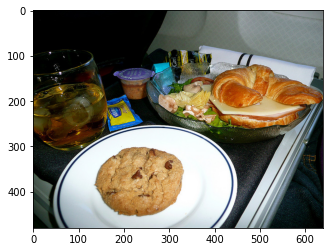

In [ ]:
plt.imshow(img_array[23])

In [ ]:
print(len(mask_array))
print(len(img_array))
print(mask.shape)
print(img.shape)

40
40
(480, 640)
(480, 640, 3)


In [ ]:
print(len(mask_array[0].shape))

2


**Create Data Generator**

In [ ]:
img_size = 160
transform = A.Compose([
    A.Resize(img_size, img_size, p=1),
    A.HorizontalFlip(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.9,p=0.2),
    A.Blur(blur_limit=5,p=0.3),
    #A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Transpose(p=0.4),
    #A.HueSaturationValue(p=0.5)
])

In [ ]:
import tensorflow.keras as keras

In [ ]:
from tensorflow.python.keras.utils.data_utils import Sequence

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, my_img_array = img_array, my_mask_array = mask_array, image_size=img_size, augmentation=False, shuffle = False, batch_size = 1, seed = 40):
    self.image_size = image_size
    self.augmentation = augmentation 
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.my_img_array = img_array
    self.my_mask_array = mask_array
    self.nb_y_features = 1 if len(mask_array[0].shape) == 2 else mask_array[0].shape[2]
    random.seed(seed)

  def __len__(self):
        return len(self.my_img_array) // self.batch_size

  def __getitem__(self, index):
     data_index_min = int(index*self.batch_size)
     data_index_max = int(min((index+1)*self.batch_size, len(self.my_img_array)))

     indexes = self.my_img_array[data_index_min:data_index_max]
     this_batch_size = len(indexes)

     X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
     y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)
     
     for i, sample_index in enumerate(indexes):
          X_sample = self.my_img_array[index * self.batch_size + i]
          y_sample = self.my_mask_array[index * self.batch_size + i]

          if self.augmentation is True:
              # Augmentation code
              #transformed_imgs, transformed_masks = transform(image=X_sample, mask = y_sample)
              #transformed_masks = transform(image=y_sample)
              #image_augm = transformed_imgs['image']
              #mask_augm = transformed_masks['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
              # divide by 255 to normalize images from 0 to 1
              #X[i, ...] = image_augm/255
              #y[i, ...] = mask_augm
              aug = transform(image = X_sample, mask = y_sample)
              img_aug = aug['image']
              mask_aug = aug['mask'].reshape(self.image_size, self.image_size, self.nb_y_features).astype(np.uint8)
              X[i, ...] = img_aug/255
              y[i, ...] = mask_aug
          else:
              pass
     return X, y
     

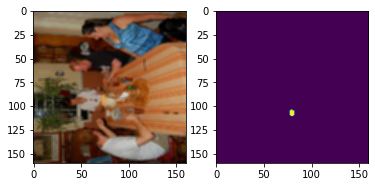

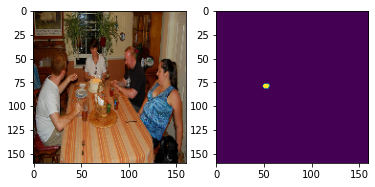

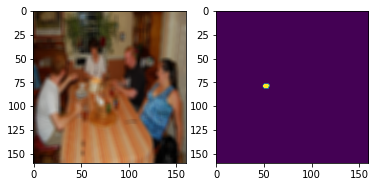

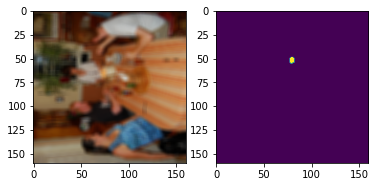

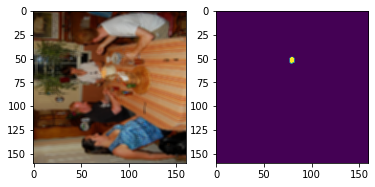

In [ ]:
train_generator = DataGenerator(my_img_array = img_array, my_mask_array = mask_array, 
                                image_size=160, augmentation=True, shuffle = False, batch_size = 3)
# val_generator = DataGenerator(my_img_array = val_img_array, my_mask_array = val_mask_array, 
#                                 image_size=160, augmentation=True, shuffle = False, batch_size = 3)
for i in range(5):
  X_sample_temp, y_sample_temp = train_generator[3]
  #plt.imshow(X_sample_temp[1])
  #plt.imshow(y_sample_temp[1,:,:,0])
  fig, ax = plt.subplots(ncols=2)
  ax[0].imshow(X_sample_temp[1])
  ax[1].imshow(y_sample_temp[1,:,:,0])
  plt.show()

In [ ]:
import tensorflow.keras as keras

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

# Build model
model = get_model((img_size,img_size), 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="rmsprop", loss = 'binary_crossentropy')

In [ ]:
model.fit(
    train_generator,
    #val_generator,
    epochs = 10,
)

Epoch 1/10
13/13 [==============================] - 38s 70ms/step - loss: 2.3433
Epoch 2/10
13/13 [==============================] - 1s 69ms/step - loss: 0.6428
Epoch 3/10
13/13 [==============================] - 1s 70ms/step - loss: 0.4784
Epoch 4/10
13/13 [==============================] - 1s 69ms/step - loss: 0.5044
Epoch 5/10
13/13 [==============================] - 1s 70ms/step - loss: 0.4763
Epoch 6/10
13/13 [==============================] - 1s 69ms/step - loss: 0.5176
Epoch 7/10
13/13 [==============================] - 1s 69ms/step - loss: 0.3755
Epoch 8/10
13/13 [==============================] - 1s 70ms/step - loss: 0.3943
Epoch 9/10
13/13 [==============================] - 1s 72ms/step - loss: 0.3973
Epoch 10/10
13/13 [==============================] - 1s 71ms/step - loss: 0.3539


In [ ]:
model.history.history

{'loss': [2.3433218002319336,
  0.6427807211875916,
  0.4784257709980011,
  0.50437992811203,
  0.47629648447036743,
  0.517583966255188,
  0.3754952847957611,
  0.39432138204574585,
  0.39733344316482544,
  0.35390254855155945]}

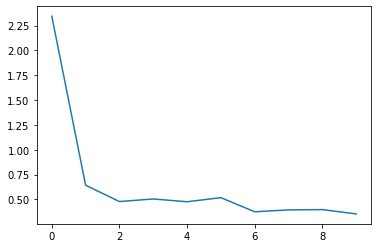

In [ ]:
plt.plot(model.history.history["loss"])

In [ ]:
# model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


In [ ]:
y_pr = model.predict(train_generator[0][0],batch_size=3)

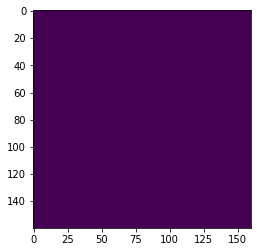

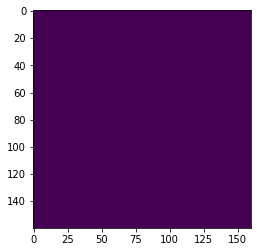

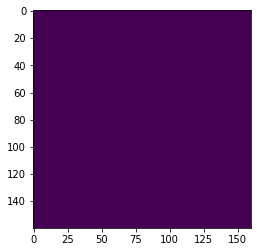

In [ ]:
for y_mask in y_pr:
  plt.imshow(y_mask[:,:,0])
  plt.show()